<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Analyse_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyse et traitements de base des séries temporelles

Dans ce carnet nous allons mettre en application les outils de base d'analyse et de traitement des séries temporelles :
  - Autocorrélation 
  - Autocorrélation partielle
  - Suppression d'une tendance linéaire d'une série
  - Différenciation non saisonnale et saisonnale
  - Suppression d'une tendance non linéaire d'une série
  - Supression d'une saisonnalité
  - Test de Dickey-Fuller (test de stationnarité)
  - Test BDS (test d'indépedance et de non-linéarité)

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.5MB 2.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Chargement des séries

In [406]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

!rm *.csv
!rm *.csv.*
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/serie_hetero.csv"
!wget -q --no-check-certificate --content-disposition  "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/serie_homo.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/serie_bb.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/serie_rw.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/serie_rw_drift.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/serie_bb_trend.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/GDP.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/Data_Airline.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/Data_Accidental.csv"


serie_hetero = pd.read_csv("serie_hetero.csv", usecols=[1], engine='python')
serie_homo = pd.read_csv("serie_homo.csv", usecols=[1], engine='python')
serie_bb = pd.read_csv("serie_bb.csv", usecols=[1], engine='python')
serie_rw = pd.read_csv("serie_rw.csv", usecols=[1], engine='python')
serie_rw_drift = pd.read_csv("serie_rw_drift.csv", usecols=[1], engine='python')
serie_bb_trend = pd.read_csv("serie_bb_trend.csv", usecols=[1], engine='python')
serie_gdp = pd.read_csv("GDP.csv", usecols=[0], engine='python')
serie_data_airline = pd.read_csv("Data_Airline.csv", usecols=[0], engine='python')
serie_data_accidental = pd.read_csv("Data_Accidental.csv", usecols=[0], engine='python')


serie_hetero = np.asarray(serie_homo.astype('float32'))[:,0]
serie_homo = np.asarray(serie_homo.astype('float32'))[:,0]
serie_bb = np.asarray(serie_bb.astype('float32'))[:,0]
serie_rw = np.asarray(serie_rw.astype('float32'))[:,0]
serie_rw_drift = np.asarray(serie_rw_drift.astype('float32'))
serie_bb_trend = np.asarray(serie_bb_trend.astype('float32'))[:,0]
serie_gdp = np.asarray(serie_gdp.astype('float32'))[:,0]
serie_data_airline = np.asarray(serie_data_airline.astype('float32'))[:,0]
serie_data_accidental = np.asarray(serie_data_accidental.astype('float32'))[:,0]

rm: cannot remove '*.csv.*': No such file or directory


#1. Bruit blanc




**1. Visualisation de la série**

Commençons par examiner une série temporelle de type **Bruit Blanc**. Ses propriétés sont les suivantes :

> $\begin{array}{l}
  E\left( {{y_t}} \right) = \mu \\
  {\mathop{\rm var}} \left( {{y_t}} \right) = {\sigma ^2}\\
  {\gamma _{t - \tau }} = \left\{ \begin{array}{l}
  {\sigma ^2}\hspace{1cm}{\rm{ si }}\:t = \tau \\
  0{\rm\hspace{1.3cm}{sinon}}
  \end{array} \right.
  \end{array}$



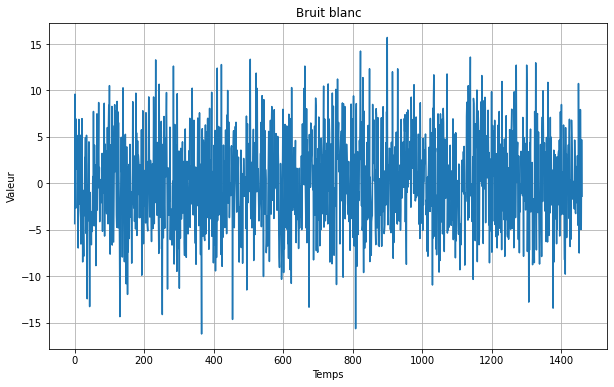

In [5]:
temps = np.linspace(0,len(serie_bb),len(serie_bb))
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie_bb)
plt.title('Bruit blanc')
plt.show()

**2. Auto-corrélation et auto-corrélation partielle**

Le fait qu'il existe une corrélation entre deux variables indique une dépendance entre elles. 

Une autocorrélation partielle permet d'obtenir une corrélation partielle d'une série temporelle avec une valeur précédente ($y_t$ et $y_{t-k}$), après prise en compte de tous les autres termes ayant un décalage plus court ($y_{t-1}$, $y_{t-2}$, $y_{t-3}$, ..., $y_{t-k+1}$). L'autocorrélation partielle permet donc d'estimer la corrélation qu'il y a entre deux décalages, et uniquement ces deux décalages (sans prendre en compte les effets des autres décalages).

Text(0.5, 1.0, 'Autocorrélation partielle du bruit blanc')

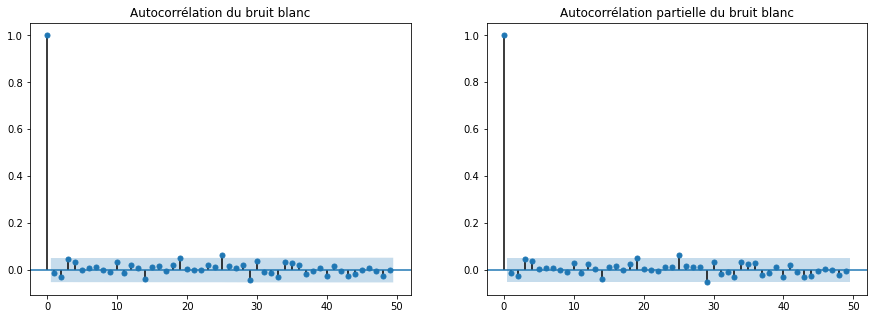

In [13]:
# ACF & PACF du bruit blanc

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_bb, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation du bruit blanc")

plot_pacf(serie_bb, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle du bruit blanc")


On peut vérifier que l'autocorrélation du bruit blanc est nulle partout sauf si le décalage est nul. De ce fait, son autocorrélation est équivalente à son autocorrélation partielle.

Les lignes horizontales représentent les bandes de confiances à 95% du niveau critique de corrélation : Les résultats de l'autocorrélation qui sont dans ces bandes nous disent qu'il y a 95% de chance que la série soit non corrélée pour la valeur de ce décalage.  

**3. Test augmenté de Dickey-Fuller**

Le test augmenté de Dickey-Fuller permet de vérifier si une série est stationnaire ou non, c'est-à-dire si la variance de la série change au court du temps ou non.  
Pour cela, le test fait l'hypothèse que la série possède au moins une racine unitaire en prenant en compte un certain nombre de décalages (voir la [documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) du test avec la librairie statsmodels).

In [7]:
import statsmodels.api as sm

serie_test = serie_bb

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -18.01862176435769
p-value: 2.699844991545792e-30,
N: 1456, 
critical values: {'1%': -3.43484922137066, '5%': -2.8635271063560412, '10%': -2.5678279184465946}


L'hypothèse de non stationarité du bruit blanc est rejettée car :
 - La **p-value** vaut 2.7e-30, ce qui signifie que la probabilité que la série soit stationnaire est quasiment nulle.
 - La **valeur critique** est de -18, ce qui est bien au-delà de la valeur critique à 1% (en valeur absolue) pour laquelle cette hypothèse serait accéptée.

#2. Bruit blanc avec tendance déterministe

**1. Visualisation de la série**

Le bruit blanc avec une tendance déterministe a la forme suivante. On parle de **tendance déterministe** car celle-ci n'est pas engendrée par un effet aléatoire :

> ${y_t} = \alpha  + \beta t + {u_t}$  

$\alpha$ : Constante (offset ou valeur moyenne)  
$\beta$ : Pente de la tendance  
$u_t$ : Bruit blanc




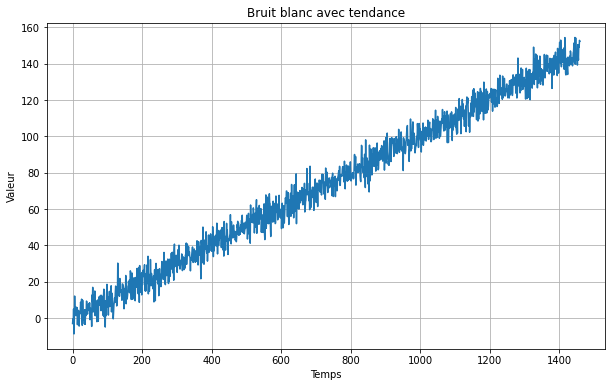

In [168]:
temps = np.linspace(0,len(serie_bb),len(serie_bb_trend))
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie_bb_trend)
plt.title('Bruit blanc avec tendance')
plt.show()

**2. Auto-corrélation et auto-corrélation partielle**

Text(0.5, 1.0, 'Autocorrélation partielle du bruit blanc avec tendance')

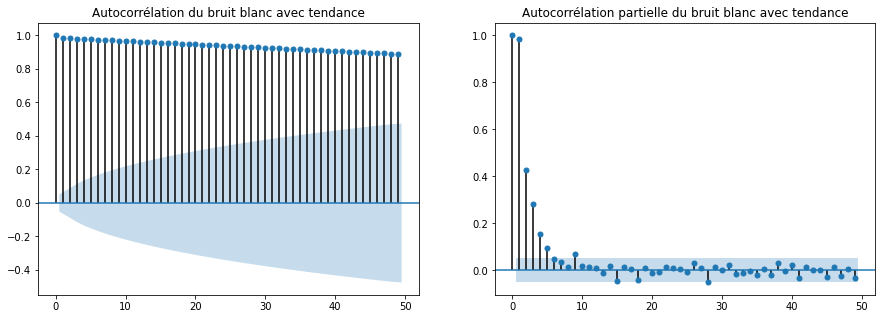

In [169]:
# ACF & PACF du bruit blanc avec tendance

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_bb_trend, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation du bruit blanc avec tendance")

plot_pacf(serie_bb_trend, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle du bruit blanc avec tendance")

On voit bien cette fois l'impact de la tendance sur le résultat de la corrélation des valeurs à différents décalages. L'ajout de la tendance apporte une corrélation sur les valeurs de la série.

**3. Supression de la tendance**

On utilise ici la fonction [detrend](https://www.statsmodels.org/stable/generated/statsmodels.tsa.tsatools.detrend.html?highlight=detrend#statsmodels.tsa.tsatools.detrend) de la librairie statmodels pour supprimer la tendance de la série.

ValueError: ignored

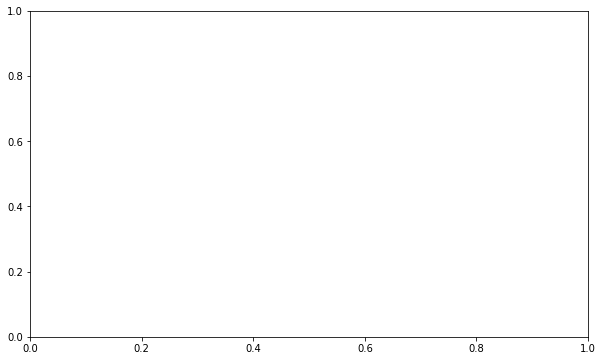

In [258]:
# Detendring du bruit blanc avec tendance
from statsmodels.tsa.tsatools import detrend

serie_bb_detrend = detrend(serie_bb_trend)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie_bb_detrend)
plt.title('Signal sans tendance')
plt.show()

Si on refait une analyse de corrélation, on retrouve bien le bruit blanc d'origine :

Text(0.5, 1.0, 'Autocorrélation partielle du bruit blanc avec tendance')

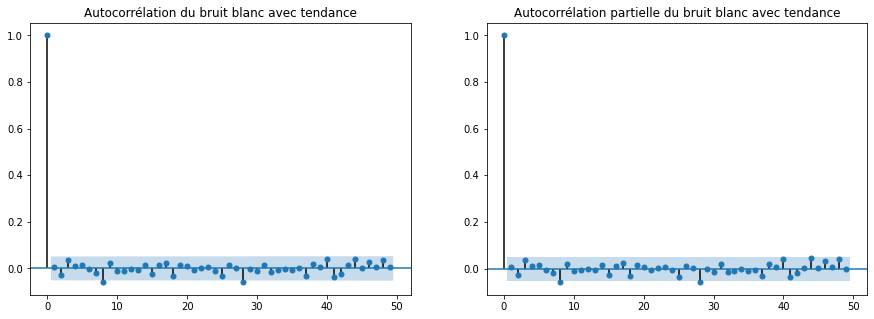

In [171]:
# ACF & PACF du signal

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_bb_detrend, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation du bruit blanc avec tendance")

plot_pacf(serie_bb_detrend, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle du bruit blanc avec tendance")

**3. Test augmenté de Dickey-Fuller**

Cette fois-ci, le test de Dickey-Fuller sera validé et donc cela montrera que la série avec tendance est non stationnaire :

In [176]:
import statsmodels.api as sm

serie_test = serie_bb_trend
#serie_test = serie_bb_detrend

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)
#adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test,regression="ct")

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -0.055510039574882736
p-value: 0.9536935267703655,
N: 1437, 
critical values: {'1%': -3.434908816804013, '5%': -2.863553406963303, '10%': -2.5678419239852994}


#3. Marche aléatoire et Marche aléatoire avec tendance

La marche aléatoire à valeur moyenne nulle ci-dessous est un process AR(1) (auto-régressif d'ordre 1) :

> ${y_t} = {y_{t - 1}} + {u_t}$  

${u_t}$ : Bruit blanc

La marche aléatoire avec tendance est une marche aléatoire à laquelle on ajoute une constante à la série :

> ${y_t} = {y_{t - 1}} + {u_t} + \alpha$


**1. Visualisation de la série**

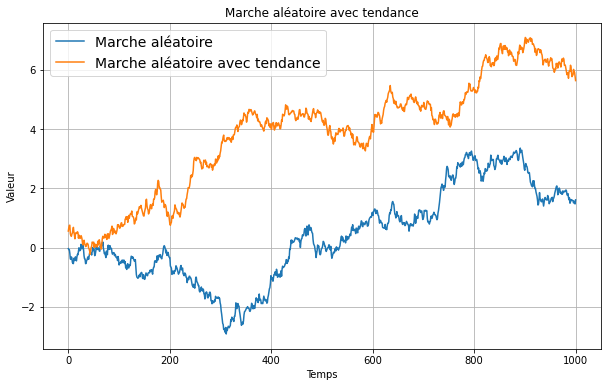

In [259]:
temps = np.linspace(0,len(serie_rw),len(serie_rw))

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie_rw,label="Marche aléatoire")
affiche_serie(temps,serie_rw_drift,label="Marche aléatoire avec tendance")
plt.title('Marche aléatoire')
plt.title('Marche aléatoire avec tendance')
plt.show()

On observe qu'il existe une tendance dans les deux cas. Ce sont des **tendances aléatoires.**

**2. Auto-corrélation et auto-corrélation partielle**

Text(0.5, 1.0, 'Autocorrélation partielle de la marche aléatoire avec tendance')

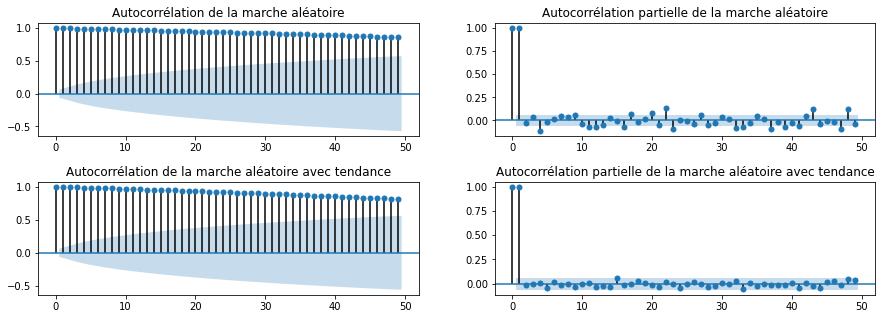

In [243]:
# ACF & PACF du random walk

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.4,wspace=0.2)

plot_acf(serie_rw, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation de la marche aléatoire")

plot_pacf(serie_rw, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle de la marche aléatoire")

plot_acf(serie_rw_drift, ax=ax3, lags = range(0,50))
ax3.set_title("Autocorrélation de la marche aléatoire avec tendance")

plot_pacf(serie_rw_drift, ax=ax4, lags = range(0, 50))
ax4.set_title("Autocorrélation partielle de la marche aléatoire avec tendance")

On observe sur le résultat de l'autocorrélation qu'il existe bien une corrélation entre les différents décalages, et que ces corrélations sont engendrées par le phénomène auto-régressif d'ordre 1 entre le décalage n°1 et l'origine.

**3. Supression de la tendance**

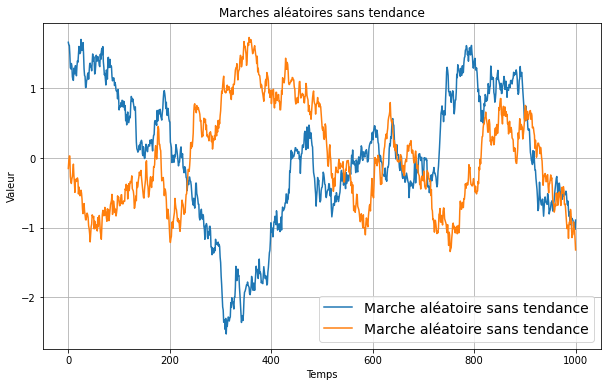

In [260]:
from statsmodels.tsa.tsatools import detrend

# Suppression de la tendance
serie_rw_detrend = detrend(serie_rw)
serie_rw_drift_detrend = detrend(serie_rw_drift)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie_rw_detrend,label="Marche aléatoire sans tendance")
affiche_serie(temps,serie_rw_drift_detrend,label="Marche aléatoire sans tendance")

plt.title('Marches aléatoires sans tendance')
plt.show()

Après avoir supprimé la tendance, on n'obtient pas un bruit blanc mais un signal qui reste corrélé du fait de la nature auto-régressive du signal. Les valeurs des corrélations sont toutefois plus faibles.

Text(0.5, 1.0, 'Autocorrélation partielle de la marche aléatoire avec tendance')

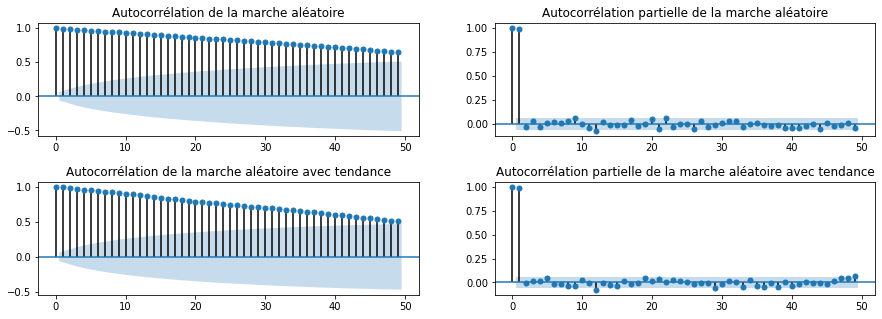

In [262]:
# ACF & PACF du random walk

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.4,wspace=0.2)

plot_acf(serie_rw_detrend, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation de la marche aléatoire")

plot_pacf(serie_rw_detrend, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle de la marche aléatoire")

plot_acf(serie_rw_drift_detrend, ax=ax3, lags = range(0,50))
ax3.set_title("Autocorrélation de la marche aléatoire avec tendance")

plot_pacf(serie_rw_drift_detrend, ax=ax4, lags = range(0, 50))
ax4.set_title("Autocorrélation partielle de la marche aléatoire avec tendance")

**4. Test augmenté de Dickey-Fuller**

Les tests ci-dessous montrent que même en ayant supprimé la tendance, la série reste non stationnaire : C'est parce que nous avons supprimé une tendance de type déterministe, alors qu'en réalité elle est aléatoire.

In [272]:
import statsmodels.api as sm

serie_test = serie_rw
serie_test = serie_rw_detrend

serie_test = serie_rw_drift
serie_test = serie_rw_drift_detrend

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -1.7469702818375608
p-value: 0.407088761556851,
N: 999, 
critical values: {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}


**4. Différenciation d'ordre 1**

Puisque le processus est un processus auto-regréssif d'odre 1, si on effectue une différenciation d'odre 1, cela supprimera la corrélation d'ordre 1. Pour différencier la série, on peut utiliser l'outils [diff](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.tools.diff.html?highlight=diff#statsmodels.tsa.statespace.tools.diff) de la librairie statmodels.

In [273]:
from statsmodels.tsa.statespace.tools import diff

# Différenciation d'ordre 1
serie_rw_diff1 = diff(serie_rw,k_diff=1)
serie_rw_drift_diff1 = diff(serie_rw_drift,k_diff=1)

Text(0.5, 1.0, 'Marche aléatoire avec tendance différencié #1')

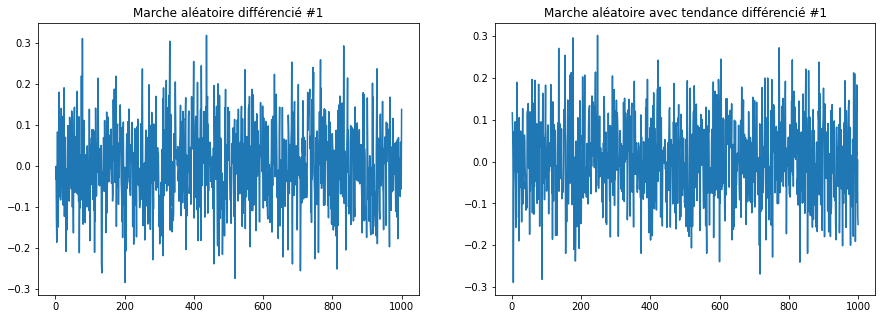

In [275]:
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

ax1.plot(temps[1:],serie_rw_diff1)
ax1.set_title("Marche aléatoire différencié #1")

ax2.plot(temps[1:],serie_rw_drift_diff1)
ax2.set_title("Marche aléatoire avec tendance différencié #1")

Text(0.5, 1.0, 'Autocorrélation partielle du signal différencié #1')

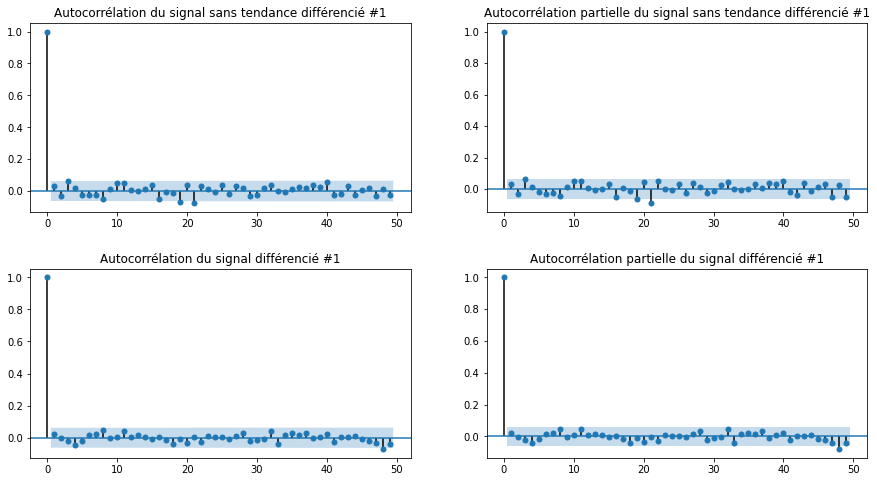

In [276]:
# ACF & PACF du signal

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(15, 8))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_rw_diff1, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation du signal sans tendance différencié #1")

plot_pacf(serie_rw_diff1, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle du signal sans tendance différencié #1")

plot_acf(serie_rw_drift_diff1, ax=ax3, lags = range(0,50))
ax3.set_title("Autocorrélation du signal différencié #1")

plot_pacf(serie_rw_drift_diff1, ax=ax4, lags = range(0, 50))
ax4.set_title("Autocorrélation partielle du signal différencié #1")

On retrouve bien un bruit blanc.

**5. Test augmenté de Dickey-Fuller**

Les tests ci-dessous montrent que :
 - La marche aléatoire est un processus non stationnaire
 - Après avoir supprimé la tendance de type déterministe, il reste stationnaire
 - Après différenciation d'odre 1, on retrouve un processus stationnaire

In [280]:
import statsmodels.api as sm

serie_test = serie_rw
serie_test = serie_rw_diff1

serie_test = serie_rw_drift
serie_test = serie_rw_drift_diff1


adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -30.788949285648634
p-value: 0.0,
N: 998, 
critical values: {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}


#4. Processus de type AR(p)

Les processus de type auto-régressifs AR(p) ont les valeurs qui ne dépendent que des valeurs précédentes de la série et d'un bruit blanc.  
La stationnarité des processus AR(p) dépend des coefficients qui la compose :

> ${y_t} = \mu  + \sum\limits_{i = 1}^p {{\phi _i}{y_{t - i}}}  + {u_t}$

$\mu$ : Offset  
$u_t$ : Bruit blanc

**1. Visualisation de la série**

Prenons les exemples de processus AR(2) ci-dessous :
- ${y_t} = u_t + 0.3y_{t-1} -0.66y_{t-2}$
- ${z_t} = u_t + 0.57z_{t-1} +0.4z_{t-2}$

Pour générer les séries, on utilise la fonction [arma generate sample](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.arma_generate_sample.html) de la librairie statmodels :

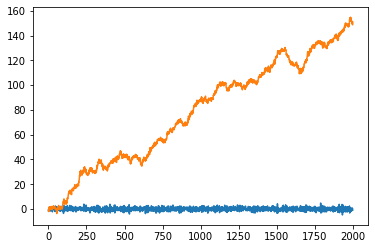

In [363]:
from statsmodels.tsa.arima_process import arma_generate_sample

# Génère une processus AR(2)
serie_ar_1 = arma_generate_sample(ar=[1,-0.3,0.6],ma=[1],nsample=2000 )
serie_ar_2 = arma_generate_sample(ar=[1,-0.57,-0.431],ma=[1],nsample=2000 )

# Affiche le résultat
plt.plot(serie_ar_1)
plt.plot(serie_ar_2)

**2. Auto-corrélation et auto-corrélation partielle**

Text(0.5, 1.0, 'Autocorrélation partielle de la série n°2 AR(2)')

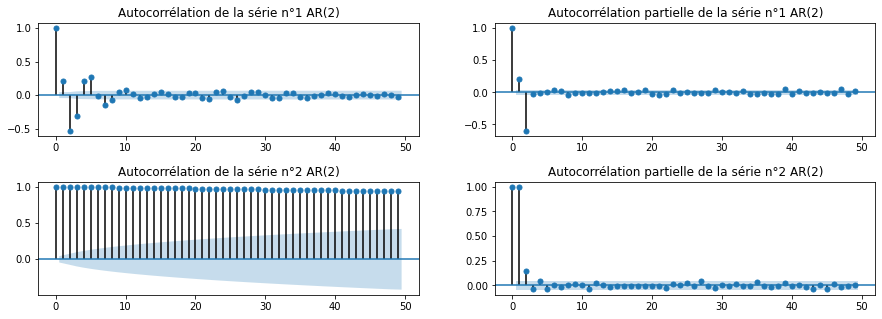

In [361]:
# ACF & PACF de la série

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.4,wspace=0.2)

plot_acf(serie_ar_1, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation de la série n°1 AR(2)")

plot_pacf(serie_ar_1, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle de la série n°1 AR(2)")

plot_acf(serie_ar_2, ax=ax3, lags = range(0,50))
ax3.set_title("Autocorrélation de la série n°2 AR(2)")

plot_pacf(serie_ar_2, ax=ax4, lags = range(0, 50))
ax4.set_title("Autocorrélation partielle de la série n°2 AR(2)")

On voit sur le PACF qu'on est bien en présence d'un processus auto-regressif d'ordre 2. On voit également que la deuxième série est davantage corrélée (au sens de l'autocorrélation) que la première série.

**6. Test augmenté de Dickey-Fuller**

In [362]:
import statsmodels.api as sm

serie_test = serie_ar_1
serie_test = serie_ar_2

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)


adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -0.4620543831535651
p-value: 0.8992110546150371,
N: 1994, 
critical values: {'1%': -3.4336337202771823, '5%': -2.8629905684254977, '10%': -2.5675422210261676}


On voit ici que la deuxième série n'est pas stationnaire, alors que la première l'est.

#5. Processus de type MA(p)

Les processus de type MA(p) (Moving Average precesses) sont des processus dont les valeurs sont corrélées avec un bruit blanc. Ce sont des processus stationnaires.

> ${y_t} = \mu  + \sum\limits_{i = 1}^p {{\phi _i}{u_{t - i}}}  + {u_t}$

$\mu$ : Offset  
$u_t$ : Bruit blanc

**1. Visualisation de la série**

Prenons l'exemple du processus : ${y_t} = u_t -0.5u_{t-1} + 0.25u_{t-2}$

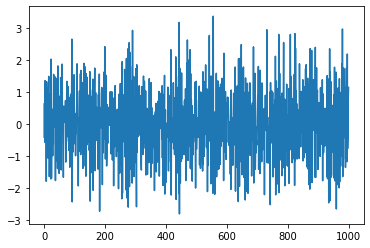

In [366]:
from statsmodels.tsa.arima_process import arma_generate_sample

# Génère une processus MA(2)
serie_ma = arma_generate_sample(ar=[1],ma=[1,-0.5,0.25],nsample=1000 )

# Affiche le résultat
plt.plot(serie_ma)

**2. ACF & PACF**

Text(0.5, 1.0, 'Autocorrélation du signal')

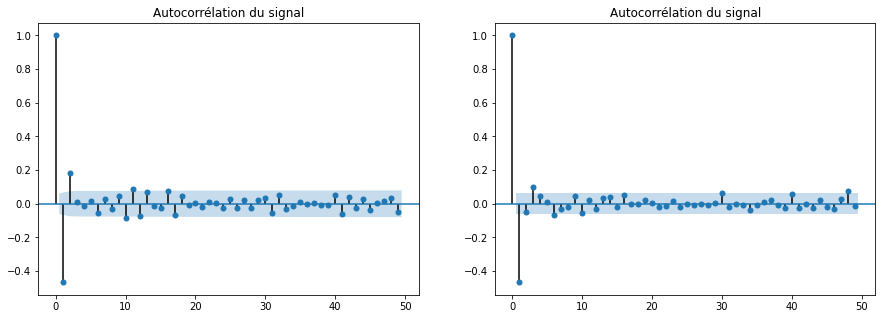

In [367]:
# ACF & PACF du signal

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_ma, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation du signal")

plot_pacf(serie_ma, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation du signal")

**3. Test augmenté de Dickey-Fuller**

Les processus de type MA(p) sont stationnaires car ils ne sont corrélés qu'avec du bruit blanc.

In [368]:
import statsmodels.api as sm

serie_test = serie_ma


adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -13.53506402434003
p-value: 2.577179783220788e-25,
N: 994, 
critical values: {'1%': -3.43694584277544, '5%': -2.8644520725172873, '10%': -2.5683205291305176}


#6. Processus de type ARMA(p)

Les processus de type ARMA(p,q) sont une combinaison des processus de types AR(p) et MA(q). Leur stationnarité dépend des coefficients des processus AR(p).

> ${y_t} = \mu  + \sum\limits_{i = 1}^p {{\phi _i}{y_{t - i}}}  + \sum\limits_{i = 1}^q {{\psi _i}{u_{t - i}}} + {u_t}$

$\mu$ : Offset  
$u_t$ : Bruit blanc

Prenons l'exemple du processus : ${y_t} = u_t -0.5u_{t-1} + 0.25u_{t-2} + 0.3y_{t-1} -0.66y_{t-2}$

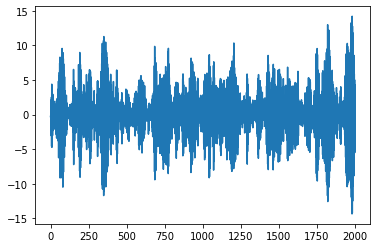

In [369]:
from statsmodels.tsa.arima_process import arma_generate_sample

# Génère une processus MA(2)
serie_arma = arma_generate_sample(ar=[1,0.3,-0.66],ma=[1,-0.5,0.25],nsample=2000 )

# Affiche le résultat
plt.plot(serie_arma)

**2. ACF & PACF**

Text(0.5, 1.0, 'Autocorrélation du signal')

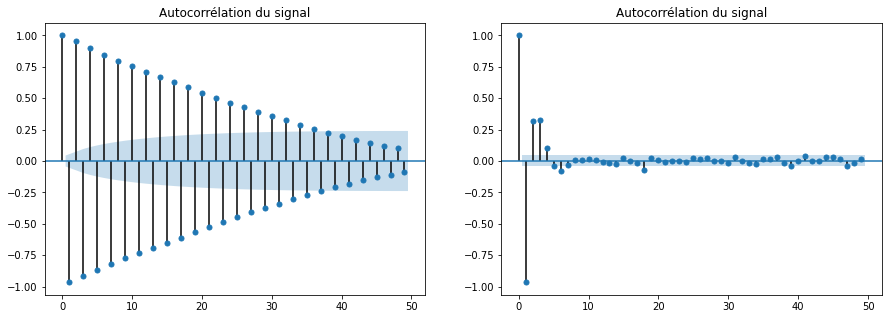

In [370]:
# ACF & PACF du signal

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_arma, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation du signal")

plot_pacf(serie_arma, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation du signal")

**3. Test augmenté de Dickey-Fuller**

In [371]:
import statsmodels.api as sm

serie_test = serie_arma


adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -15.091883987675761
p-value: 8.170893788399722e-28,
N: 1993, 
critical values: {'1%': -3.43363537003345, '5%': -2.862991296796771, '10%': -2.5675426088474738}


#7. Data Airline - Différenciation non saisonnale et saisonnale

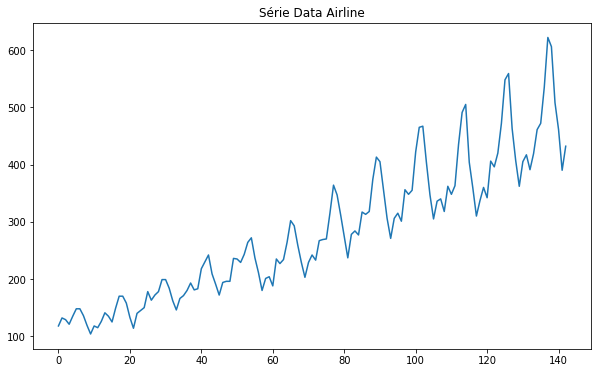

In [422]:
plt.figure(figsize=(10, 6))
plt.plot(serie_data_airline)
plt.title('Série Data Airline')
plt.show()

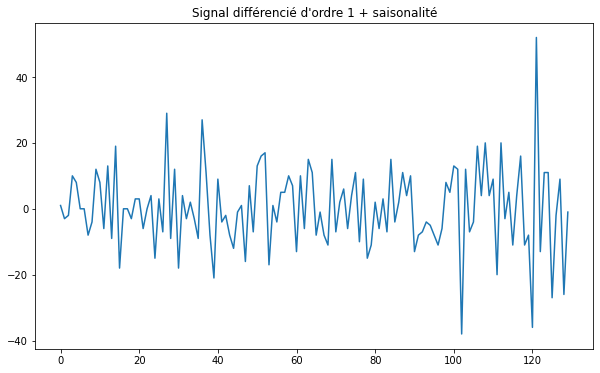

In [424]:
# Différenciation d'odre 1 et saisonnale à l'odre 1 et de période 12

from statsmodels.tsa.statespace.tools import diff

serie_data_airline_sdiff1 = diff(serie_data_airline,1,1,12)       # diff=1 ; diff_saison=1 ; periode = 12


plt.figure(figsize=(10, 6))
plt.plot(serie_data_airline_sdiff1)
plt.title("Signal différencié d'ordre 1 + saisonalité")
plt.show()

In [427]:
import statsmodels.api as sm

serie_test = serie_data_airline
serie_test = serie_data_airline_sdiff1


adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: 0.792339995969247
p-value: 0.9915115096288658,
N: 129, 
critical values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}


#8. Accidents - Extraction de la saisonnalité

**1. Affichage de la série : Morts par accidents 1973-1978 aux Etats Unis**

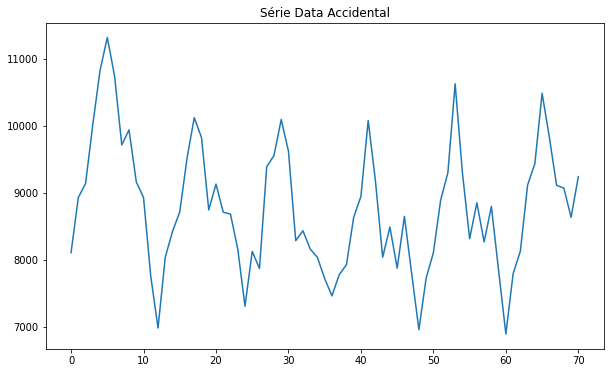

In [443]:
plt.figure(figsize=(10, 6))
plt.plot(serie_data_accidental)
plt.title('Série Data Accidental')
plt.show()

**2. Tendance quadratique**

L'objectif est ici de trouver le polynome : P = ax4+bx3+cx2+dx+c

Text(0.5, 1.0, 'Série avec tendance non linéaire supprimée')

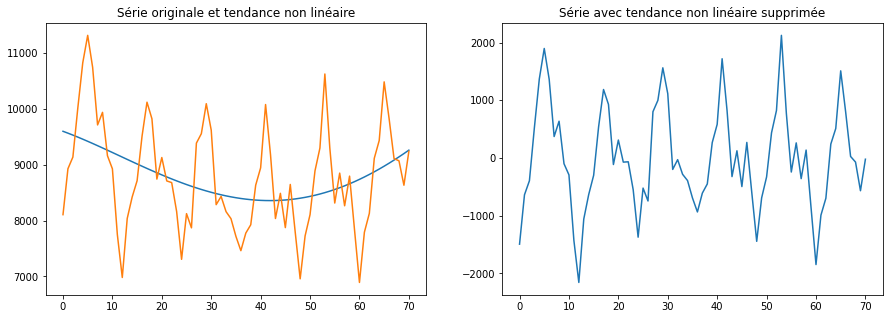

In [444]:
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Calcul des coefficients
x = np.linspace(0,len(serie_data_accidental),len(serie_data_accidental))
coefs = np.polyfit(x,serie_data_accidental,4)

# Calcul de la tendance non linéaire
trend = coefs[0]*np.power(x,4) + coefs[1]*np.power(x,3) + coefs[2]*np.power(x,2) + coefs[3]*np.power(x,1) + coefs[4]

# Calcul de la série sans tendance
serie_data_accidental_detrend = serie_data_accidental - trend

# Affiche les résultats
ax1.plot(trend)
ax1.plot(serie_data_accidental)
ax1.set_title("Série originale et tendance non linéaire")

ax2.plot(serie_data_accidental_detrend)
ax2.set_title("Série avec tendance non linéaire supprimée")

**3. Analyse de la saisonnalité**

Text(0.5, 1.0, 'FFT')

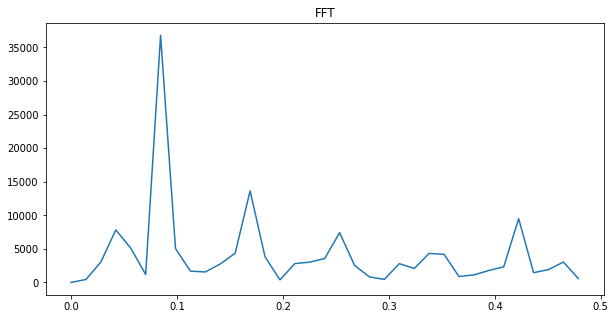

In [445]:
from scipy.fft import fft, fftfreq

f1, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Calcul de la FFT de la série
N = len(serie_data_accidental_detrend)
T = 1.0

fft=fft(serie_data_accidental_detrend)[:np.asarray(N/2).astype(int)]
freqs = fftfreq(N,T)[:np.asarray(N/2).astype(int)]

# Affichage
ax1.plot(freqs,abs(fft))
ax1.set_title("FFT")

Fréquences : [11.83333333  5.91666667]


Text(0.5, 1.0, 'FFT')

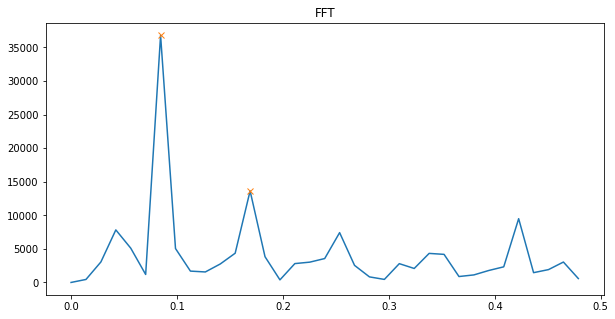

In [432]:
from scipy.signal import find_peaks

f1, ax1 = plt.subplots(1, 1, figsize=(10, 5))

peaks, _ = find_peaks(abs(fft), height=(10000))

print("Fréquences : %s" %(1.0/freqs[peaks]))

# Affichage
ax1.plot(freqs,abs(fft))
ax1.plot(freqs[peaks],abs(fft[peaks]),'x')
ax1.set_title("FFT")

**4. Extraction de la tendance et de la saisonnalité**

On peut utiliser l'outil [STL](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL) de la librairie statmodels pour extraire la saisonnalité et la tendance d'une série.

Text(0.5, 1.0, 'Série sans tendance ni saisonnalité')

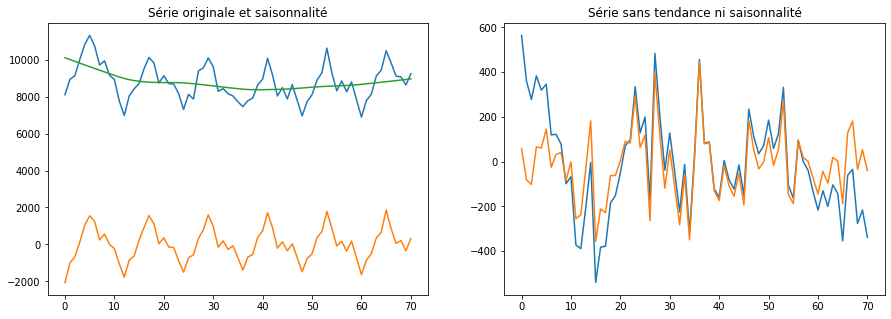

In [447]:
from statsmodels.tsa.seasonal import STL

stl = STL(serie_data_accidental, period=12)
res = stl.fit()

serie_data_accidental_saison = res.seasonal
serie_data_accidental_trend = res.trend
serie_data_accidental_resid = res.resid

# Affiche les résultats
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(serie_data_accidental)
ax1.plot(serie_data_accidental_saison)
ax1.plot(serie_data_accidental_trend)

ax1.set_title("Série originale et saisonnalité")

ax2.plot(serie_data_accidental_detrend - serie_data_accidental_saison)
ax2.plot(serie_data_accidental_resid)

ax2.set_title("Série sans tendance ni saisonnalité")

In [438]:
import statsmodels.api as sm

serie_test = serie_data_accidental
serie_test = serie_data_accidental_detrend
serie_test = serie_data_accidental_detrend - serie_data_accidental_saison
serie_test = serie_data_accidental_resid

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -7.331851224870528
p-value: 1.1224753097925005e-10,
N: 70, 
critical values: {'1%': -3.5274258688046647, '5%': -2.903810816326531, '10%': -2.5893204081632653}


#9. Série Hétéroscédastique

Un série hétéroscédastique (contrairement à une série homoscédastique) est un processus avec un bruit qui dépend du temps, et donc une série avec une variance variable dans le temps. 
> ${y_t} = \mu  + \sum\limits_{i = 1}^p {{\phi _i}{y_{t - i}}}  + {u_t}$

Avec : ${u_t} \sim N\left( {0,\sigma _{n,t}^2} \right)$

**1. Visualisation de la série**

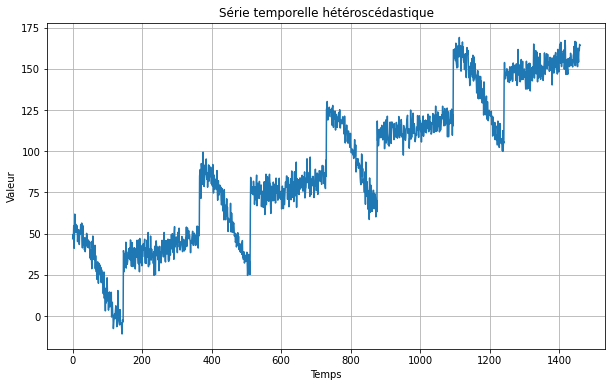

In [439]:
temps = np.linspace(0,len(serie_bb),len(serie_homo))

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie_hetero)
plt.title('Série temporelle hétéroscédastique')
plt.show()

**2. Auto-corrélation et auto-corrélation partielle**

Text(0.5, 1.0, 'Autocorrélation partielle de la série Homoscédatique')

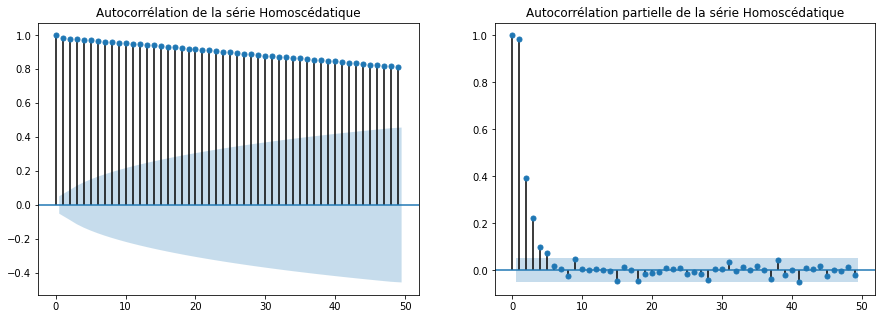

In [440]:
# ACF & PACF de la série Homoscédatique

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_hetero, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation de la série Homoscédatique")

plot_pacf(serie_hetero, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle de la série Homoscédatique")

On voit sur cette série que c'est certainement un processus auto-regressif d'ordre 5.

**3. Suppression de la tendance**

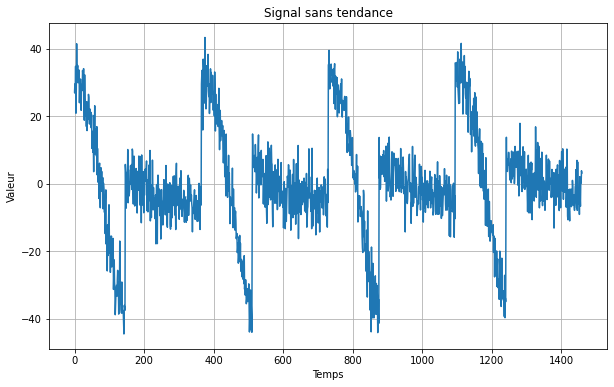

In [409]:
# Detendring de la série homoscédatique
from statsmodels.tsa.tsatools import detrend

serie_hetero_detrend = detrend(serie_hetero)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie_hetero_detrend)
plt.title('Signal sans tendance')
plt.show()

La suppression de la tendance permet de rendre la série stationnaire :

In [453]:
import statsmodels.api as sm

serie_test = serie_hetero
serie_test = serie_hetero_detrend

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -4.164102487541944
p-value: 0.0007574092306769291,
N: 1455, 
critical values: {'1%': -3.4348523191002123, '5%': -2.8635284734563364, '10%': -2.567828646449617}


Text(0.5, 1.0, 'Autocorrélation partielle de la série Homoscédatique')

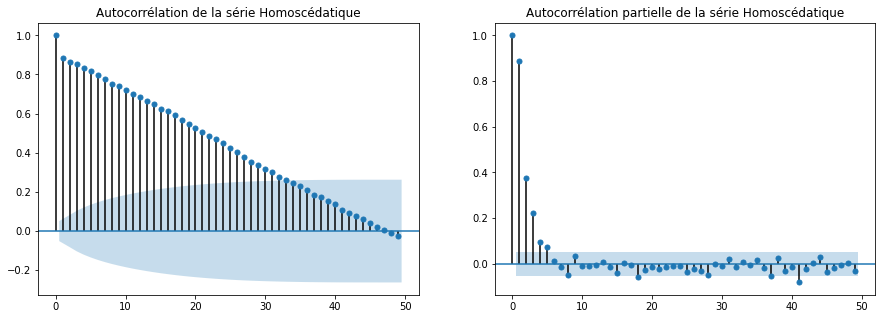

In [454]:
# ACF & PACF de la série

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_hetero_detrend, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation de la série hétéroscédastique")

plot_pacf(serie_hetero_detrend, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle de la série hétéroscédastique")

**4. Extraction de la saisonnalité et de la tendance**

Text(0.5, 1.0, 'Série résiduelle')

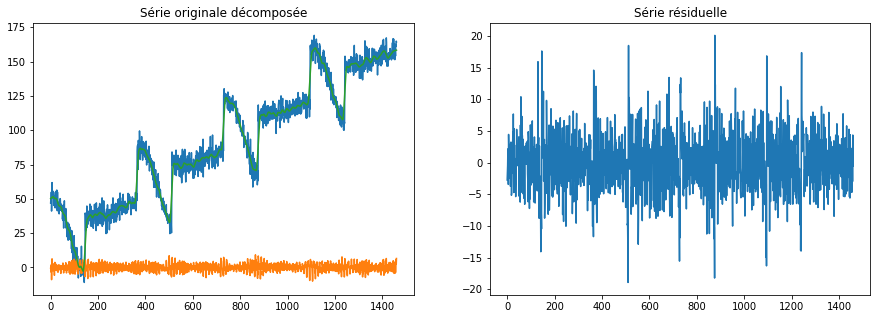

In [456]:
from statsmodels.tsa.seasonal import STL

stl = STL(serie_hetero, period=12)
res = stl.fit()

serie_hetero_saison = res.seasonal
serie_hetero_trend = res.trend
serie_hetero_resid = res.resid

# Affiche les résultats
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(serie_hetero)
ax1.plot(serie_hetero_saison)
ax1.plot(serie_hetero_trend)

ax1.set_title("Série originale décomposée")

ax2.plot(serie_hetero_resid)

ax2.set_title("Série résiduelle")

Les résidus obtenus sont stationnaires :

In [464]:
import statsmodels.api as sm

serie_test = serie_hetero_resid


adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -12.555239051963785
p-value: 2.1616654289923156e-23,
N: 1435, 
critical values: {'1%': -3.4349151819757466, '5%': -2.863556216004778, '10%': -2.5678434198545568}


Les résidus ne contiennent pas que du bruit blanc :

Text(0.5, 1.0, 'Autocorrélation partielle des résidus')

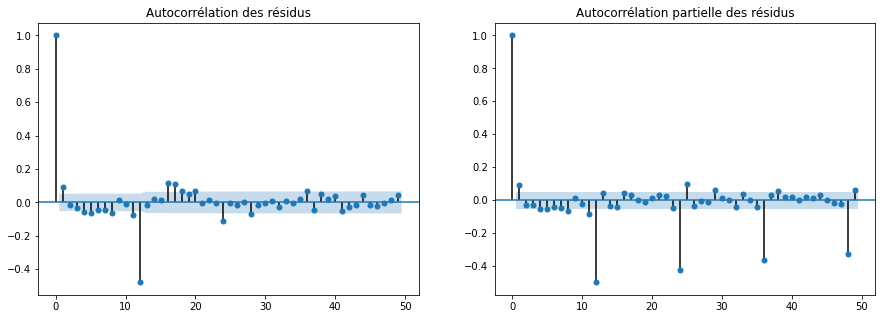

In [466]:
# ACF & PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_hetero_resid, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation des résidus")

plot_pacf(serie_hetero_resid, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle des résidus")